# Fish Weight Estimation

This project has the objective to demonstrate the use of different models of machine learning to predict the weight of fish.

The dataset used in this project was the ["Fish market"](https://www.kaggle.com/aungpyaeap/fish-market).

# Libraries

In [1]:
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Data

In [2]:
data = pd.read_csv('Fish.csv')

data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


### Renaming features

In [3]:
data.rename(columns={'Length1':'Vertical length', 
                     'Length2':'Diagonal length', 
                     'Length3':'Cross length'}, 
            inplace=True)

# Analyzing  data

### Data description

In [4]:
data.describe()

,Weight,Vertical length,Diagonal length,Cross length,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


### Visualizing features - Box and violin plot

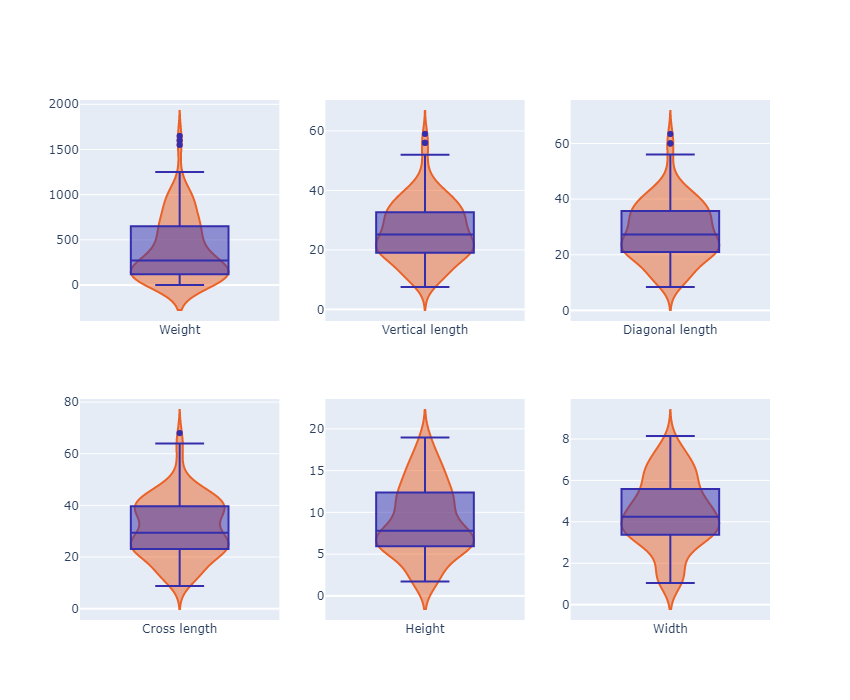

In [5]:
features_to_plot = {'Weight':[1,1], 
                    'Vertical length':[1,2], 
                    'Diagonal length':[1,3], 
                    'Cross length':[2,1], 
                    'Height':[2,2], 
                    'Width':[2,3]}

box_violin_plot = make_subplots(rows=2, cols=3)

for i in features_to_plot.keys():
    box_violin_plot.add_trace(go.Box(y=data[i], name=i, marker_color='#342ead'), 
                              row=features_to_plot[i][0], col=features_to_plot[i][1])
    box_violin_plot.add_trace(go.Violin(y=data[i], name=i, marker_color='#ea6227'), 
                              row=features_to_plot[i][0], col=features_to_plot[i][1])
    
box_violin_plot.update_layout(showlegend=False)

box_violin_plot.show('png', width=850, height=700)

Notes:
 - In general, the features apresents a normal distribution;
 - Existence of some outliers in features. As in weight, vertical length, diagonal length and cross length;
 - The difference between the scale of our features can be a problem.

### Visualizing features  - Scatter plot

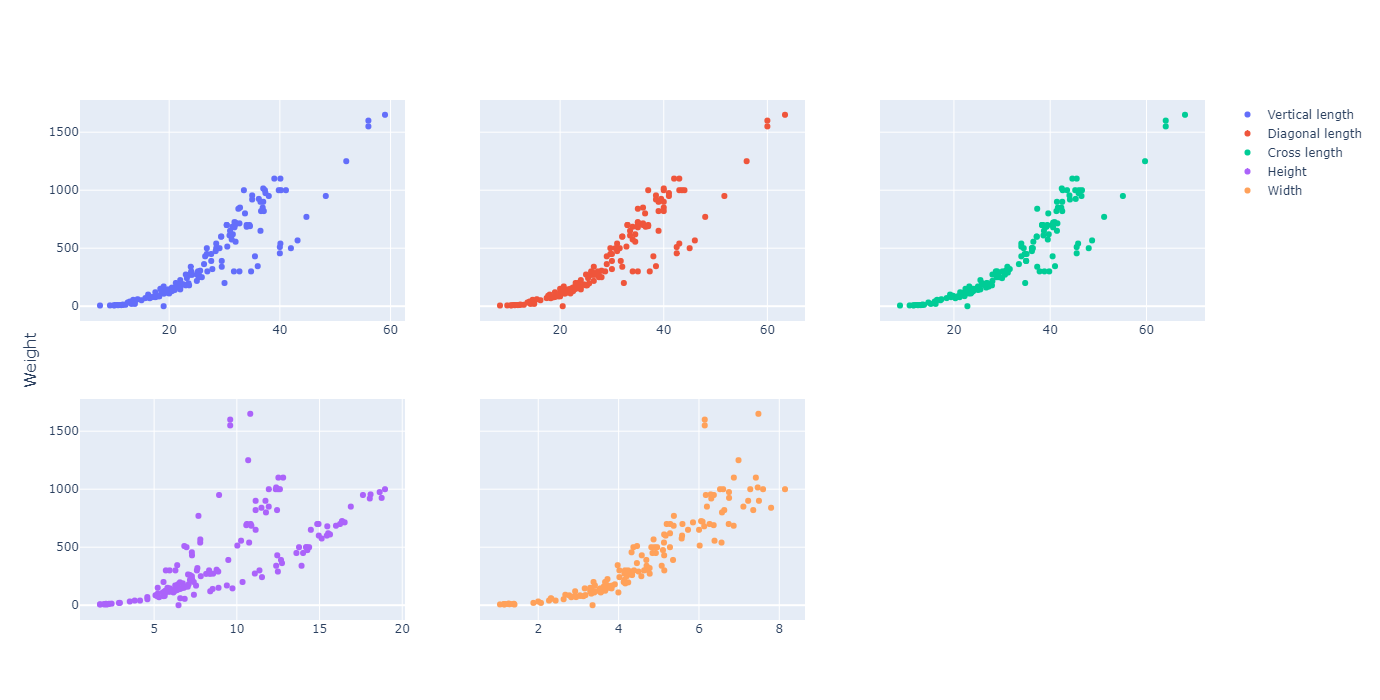

In [6]:
features_to_plot = {'Vertical length':[1,1], 
                    'Diagonal length':[1,2], 
                    'Cross length':[1,3], 
                    'Height':[2,1], 
                    'Width':[2,2]}

scatter_fig = make_subplots(rows=2, cols=3,   y_title='Weight', shared_yaxes=True)

for i in features_to_plot.keys():
    scatter_fig.add_trace(go.Scatter(x=data[i], y=data['Weight'], mode='markers', name=i), 
                          row=features_to_plot[i][0], col=features_to_plot[i][1])

scatter_fig.show('png', width=1380, height=700)

# Preparing the data

### Removing outliers

In [7]:
for k in data.columns.to_list()[1:]:
    percentile_25 = np.percentile(data[k], 25)
    percentile_75 = np.percentile(data[k], 75)
    iqr = percentile_75 - percentile_25
    lower = percentile_25 - (iqr*1.5)
    upper = percentile_75 + (iqr*1.5)
    for i in data[k]:
        if ((i > upper) or (i < lower)):
            data.drop((data.index[data[k] == i].to_list()), axis=0, inplace=True)

### Encoding features

In [8]:
encoder = LabelEncoder()

data['Species']  = encoder.fit_transform(data['Species'])

### Defining variables

In [9]:
X = data.drop(['Weight'], axis=1)

y = data['Weight']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model - Linear regression

### Creating model

In [10]:
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)

y_pred = linear_regression.predict(X_test)

### Results - Evaluating model

In [11]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rsq = r2_score(y_test, y_pred)

print('RMSE:', rmse)

print('\nR Square:', rsq)

RMSE: 96.11474304076621

R Square: 0.9167180805347467


### Results - Actual values x Predicted values

In [12]:
df_comparison = pd.DataFrame({'Actual values' : y_test,
                               'Predicted values' : y_pred})

df_comparison.head()

,Actual values,Predicted values
129,300.0,257.928221
93,145.0,147.891841
158,19.9,-21.119663
77,100.0,39.694499
21,685.0,677.714917


In [13]:
df_comparison[df_comparison['Actual values'] <= 50] # Selecting only very low weights to confirm a model problem

,Actual values,Predicted values
158,19.9,-21.119663
73,32.0,-114.101415
152,9.9,-92.810227


Note:
- As we can see, this linear model performs well for the most part of weights , but has difficulty to predict very low weights.

# Model - Polynomial regression

### Generating polynomial features

In [14]:
polynomial_features = PolynomialFeatures(degree=2)

polynomial_features.fit(X_train)

X_train_poly = polynomial_features.transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

### Creating model

In [15]:
polynomial_regression = LinearRegression()

polynomial_regression.fit(X_train_poly, y_train)

y_pred = polynomial_regression.predict(X_test_poly)

### Results - Evaluating model

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rsq = r2_score(y_test, y_pred)

print('RMSE:', rmse)

print('\nR Square:', rsq)

RMSE: 55.78171995921545

R Square: 0.971948602016236


### Results - Actual values x Predicted values

In [17]:
df_comparison = pd.DataFrame({'Actual values' : y_test,
                               'Predicted values' : y_pred})

df_comparison.head()

,Actual values,Predicted values
129,300.0,273.331055
93,145.0,127.074463
158,19.9,23.139160
77,100.0,73.891602
21,685.0,618.201172


# Model - Random forest regression

### Creating model

In [18]:
random_forest = RandomForestRegressor(n_estimators=10, max_depth=7)

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

### Results - Evaluating model

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

rsq = r2_score(y_test, y_pred)

print('RMSE:', rmse)

print('\nR Square:', rsq)

RMSE: 57.584213236992774

R Square: 0.9701064437940522


### Results - Actual values x Predicted values

In [20]:
df_comparison = pd.DataFrame({'Actual values' : y_test,
                               'Predicted values' : y_pred})

df_comparison.head()

,Actual values,Predicted values
129,300.0,315.357143
93,145.0,136.225962
158,19.9,37.476429
77,100.0,52.859091
21,685.0,635.466667
